<a href="https://colab.research.google.com/github/TaoM1992/gh-exercise/blob/master/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4

### Shiqi Tao

In [15]:
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
import cv2
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models, transforms

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import pandas as pd
# create a dataframe for our image data
data_path = '/content/gdrive/My Drive/afhq'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

16130


,image_file,label,dataset,image_path
0,pixabay_cat_000037.jpg,cat,val,/content/gdrive/My Drive/afhq/val/cat
1,flickr_cat_000320.jpg,cat,val,/content/gdrive/My Drive/afhq/val/cat
2,flickr_cat_000108.jpg,cat,val,/content/gdrive/My Drive/afhq/val/cat
3,flickr_cat_000123.jpg,cat,val,/content/gdrive/My Drive/afhq/val/cat
4,flickr_cat_000238.jpg,cat,val,/content/gdrive/My Drive/afhq/val/cat


In [4]:
# training and validation data
df_train = df[df['dataset'] == 'train'].reset_index(drop=True)
df_val = df[df['dataset'] == 'val'].reset_index(drop=True)
len(df_train), len(df_val)

(14630, 1500)

In [5]:
from tqdm.notebook import tqdm
import time

def resize_img(path, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(path, img)
    return end - start

# resize all of the images to 256x256
total_time_resize = 0.0
for idx in tqdm(range(len(df_train))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    
for idx in tqdm(range(len(df_val))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    

In [8]:
# let's add an augmentation option
class AnimalFacesDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # label dictionary
        self.label_dict = {'cat':0, 'dog':1, 'wild':2}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform the image
        # certain transformations expect the uint8 datatype
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [9]:
ds_train = AnimalFacesDataset(df_train, augment=True)
dl_train = DataLoader(ds_train, batch_size = 16, shuffle=True)

ds_val = AnimalFacesDataset(df_val)
dl_val = DataLoader(ds_val, batch_size = 16, shuffle=True)

In [12]:
img, label = next(iter(ds_train))
print(img.shape)

torch.Size([3, 224, 224])


##### 1. What is the dimension of a tensor after the first Basic Block in ResNet-18? Describe each change in dimension, what layer and why does it change?

In [16]:
outputs= []
img = img.reshape([1, 3, 224, 224])
def hook(module, input, output):
    outputs.append(output)

resnet = models.resnet18(pretrained=True)
resnet.layer1[0].register_forward_hook(hook)
out = resnet(img)
#out = resnet(res1)
for o in outputs:
    print(o.size())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



torch.Size([1, 64, 56, 56])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from torchsummary import summary
summary(resnet, input_size = (3, 224, 224), device='cuda')

For an image input of size (3, 224, 224), the tensor's dimension after the first Basic Block in ResNet-18 is (1, 64, 56, 56). The dimension after Maxpooling is already (1, 64, 56, 56), since the Conv2d in the first Basic Block uses kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), it doesn't change the size, neither does the BatchNorm2d and ReLU. 

##### 2. Read the Albumentations GitHub ReadMe. Pick your favorite augmentation (pick a weird one for fun). Implement it with probability p = 1 and see how it affects an image.

In [17]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

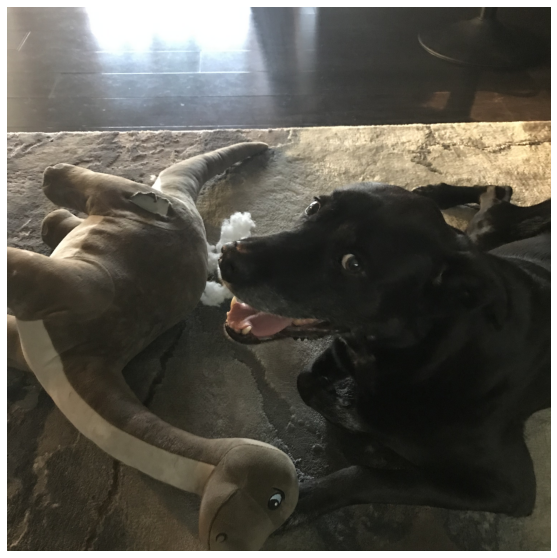

In [18]:
image = cv2.imread('kody_2.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

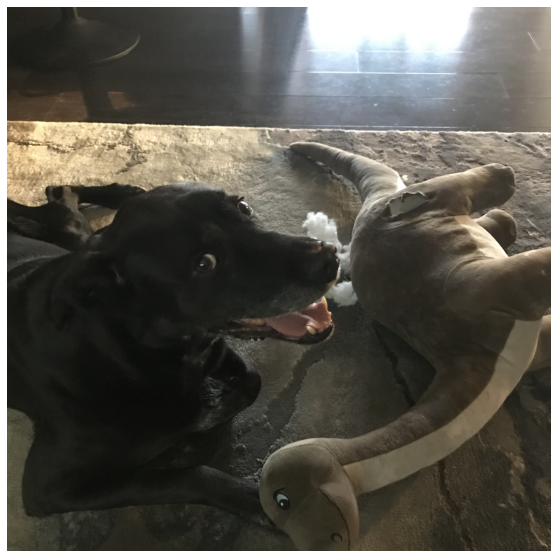

In [19]:
transform = A.HorizontalFlip(p=1)
random.seed(7)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

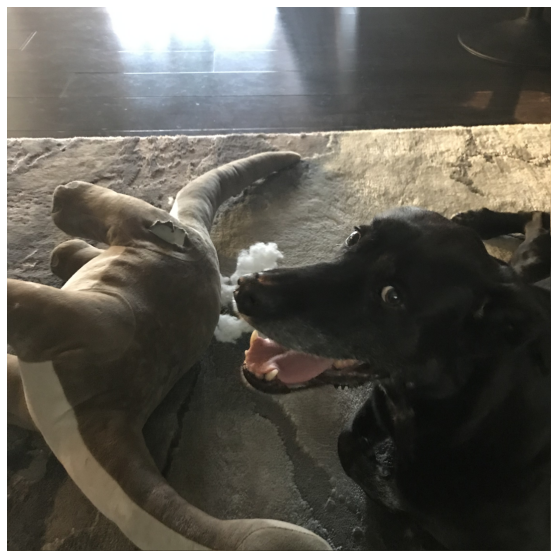

In [20]:
transform = A.GridDistortion(p=1)
random.seed(7)
augmented_image = transform(image=image)['image']
visualize(augmented_image)


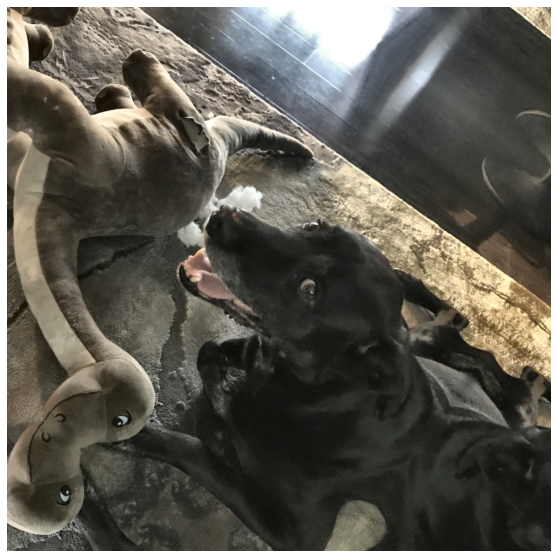

In [21]:
transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=1),
    A.Blur(blur_limit=9, p=1),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
random.seed(42) 
augmented_image = transform(image=image)['image']
visualize(augmented_image)

##### 3. Fix a reasonable suite of data augmentations for your training data. Compare the performance of three models on the animal faces dataset:

- frozen AlexNet

In [33]:
alex = models.alexnet(pretrained=True)

In [34]:
# turn off gradients for all the parameters
for param in alex.parameters():
            param.requires_grad = False

In [35]:
summary(alex, input_size = (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [36]:
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [37]:
print(alex.classifier)
alex.classifier = nn.Linear(9216, 3)
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Linear(in_features=9216, out_features=3, bias=True)


In [38]:
# pass the appropriate parameters to the optimizer
params_to_update = []

for param in alex.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [39]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [40]:
from tqdm.notebook import tqdm

lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(alex, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(alex, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(alex, dl_train, len(ds_train))
    valid_acc = one_pass_acc(alex, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0



Train loss:  0.28181731231510965



Valid loss:  3.2078924723900855
Train Acc:  0.9806561859193438
Valid Acc:  0.768
Epoch:  1



Train loss:  0.2290265486093818



Valid loss:  2.0972808504290135
Train Acc:  0.9816814764183185
Valid Acc:  0.846
Epoch:  2



Train loss:  0.2454376286060257



Valid loss:  1.7693955708134725
Train Acc:  0.9824333561175667
Valid Acc:  0.8726666666666667
Epoch:  3



Train loss:  0.23281594317659526



Valid loss:  1.8458235490716348
Train Acc:  0.9885167464114832
Valid Acc:  0.8853333333333333
Epoch:  4



Train loss:  0.2580224577361849



Valid loss:  3.1272500525644484
Train Acc:  0.989542036910458
Valid Acc:  0.852



- finetuned AlexNet

In [58]:
list(alex.children())[2]

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [60]:
class Tune_AlexNet(nn.Module):
    def __init__(self):
        super(Tune_AlexNet, self).__init__()
        alex = models.alexnet(pretrained=True)
        layers = list(alex.children())[:3]
        self.features1 = nn.Sequential(*layers[:1])
        self.features2 = nn.Sequential(layers[1])
        self.classifier = nn.Linear(9216, 3)
        self.unroll = nn.Flatten()
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.unroll(x)
        x = self.classifier(x)
        return x
    
model = Tune_AlexNet()
summary(model, input_size = (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [61]:
lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0



Train loss:  1.4356071529492656



Valid loss:  1.4716323709234278
Train Acc:  0.3834586466165414
Valid Acc:  0.32666666666666666
Epoch:  1



Train loss:  1.4334577678982678



Valid loss:  1.4704029078179217
Train Acc:  0.377717019822283
Valid Acc:  0.32666666666666666
Epoch:  2



Train loss:  1.4343138432893596



Valid loss:  1.4709121381982844
Train Acc:  0.38557758031442246
Valid Acc:  0.32666666666666666
Epoch:  3



Train loss:  1.4356907717517164



Valid loss:  1.4721444788131308
Train Acc:  0.380997949419002
Valid Acc:  0.32666666666666666
Epoch:  4



Train loss:  1.4210109057322227



Valid loss:  1.4705380943227322
Train Acc:  0.381408065618592
Valid Acc:  0.32666666666666666



- AlexNet from scratch (set pretrained=False)

In [50]:
alex = models.alexnet(pretrained=False)

In [51]:
summary(alex, input_size = (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [52]:
optimizer = optim.Adam(params_to_update, lr=0.001)

In [53]:
lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(alex, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(alex, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(alex, dl_train, len(ds_train))
    valid_acc = one_pass_acc(alex, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0



Train loss:  6.912017966619606



Valid loss:  6.910722889798753
Train Acc:  0.0
Valid Acc:  0.0
Epoch:  1



Train loss:  6.911952648267069



Valid loss:  6.910715590132043
Train Acc:  0.0
Valid Acc:  0.0
Epoch:  2



Train loss:  6.911950595522187



Valid loss:  6.9107247971473855
Train Acc:  0.0
Valid Acc:  0.0
Epoch:  3



Train loss:  6.911937479634102



Valid loss:  6.910713408855682
Train Acc:  0.0
Valid Acc:  0.0
Epoch:  4



Train loss:  6.911974901710051



Valid loss:  6.910720206321554
Train Acc:  0.0
Valid Acc:  0.0

